# Solar System Views - Trans-Neptunian Objects

Plot the positions of outer solar system planets and TNOs at a given viewing epoch in 2 views:
 * looking down from "above" at the projection onto the ecliptic plane (X,Y)
 * looking from the "side" along the X-axis at the projection onto the (Y,Z) plane

Uses `astroquery` to get data from the MPC and JPL Horizons databases.

TNOs and Centaurs are defined here as all objects with a>20au and q>5.2 (orbit of Jupiter). This isn't perfect but good enough for 
illustration purposes.

In [25]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

# astropy bits we need

from astropy.time import Time

# used for Newton-Raphson root solving for this plot

from scipy.optimize import newton

# astroquery

from astroquery.mpc import MPC
from astroquery.jplhorizons import Horizons

# suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)

## Standard Plot Format

#### Aspect Ratio

`aspect` sets the aspect ratio, width/height.  The default aspect ratio is 4:3, 1:1 for square plots, 
and 5:2 (2.5:1) for spectra, and equal aspect ratio for images and plots of Cartesian coordinates.
Use a formula instead of decimal when the result is a fraction (example: `aspect = 4.0/3.0` instead of
`aspect=1.33`).

In [26]:
# Aspect ratio
#
# Exceptions:
#    spectra use full width we use 5:2=2.5 aspect ratio
#
# graphic aspect ratio = width/height

aspect = 1.0 #16.0/9.0

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 1.0

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 7
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## convenience functions

a_pq(a_p,p,q) = semi-major axis of a p:q resonance for perturber at a_p


In [27]:
def a_pq(a_p,p,q):
    return a_p*(p/q)**(2./3.)

# Plot an unfilled circle of a given radius

def plotCircle(ax,xc,yc,r,color,ltype='-',alpha=0):
    theta = np.linspace(0,2*np.pi,360,endpoint=True)
    xs = xc + r*np.cos(theta)
    ys = yc + r*np.sin(theta)
    ax.plot(xs,ys,linestyle=ltype,color=color,alpha=alpha,lw=0.5)

## Orbit calculation and transform functions

### Eccentric anomaly, $E$

The mean anomaly $M$ is related to the eccentric anomaly $E$ and eccentricity $e$ by Kepler's equation:
 > $M = E - e\sin(E)$

Kepler's equation cannot be solved analytially to compute $E$ given $M$ and $e$ from the orbit elements, so
we solve it numerically using the Newton-Raphson method.  

Define a function $f(E)$
 > $f(E) = E - e\sin(E) - M$

with derivative
 > $\frac{dfE}{dE} = 1 - e\cos(E)$

And solve for $f(E)=0$ given $M$ and $e$.  We will use the `scipy.optimize.newton()` function to solve
for the roots using the Newton-Raphson method.

### True anomaly, $\nu$

Compute the true anomaly $\nu$ given the eccentric anomaly $E$ and orbit eccentricity $e$, using a form that
is numerically safe when E is near $\pm\pi$:
\begin{equation}
  \nu = E + 2\arctan\left(\frac{\beta\sin E}{1-\beta\cos E}\right)
\end{equation}
where
\begin{equation}
  \beta = \frac{e}{1+(1-e^2)^{1/2}}
\end{equation}

### Orbital elements to ecliptic reference plane (x,y,z) coordinates

For a given epoch and osculating orbit elements (a,e,i,n,$\Omega$,$\omega$), `orbXYZ()` computes the
ecliptic reference plane (x,y,z) location of the object at that epoch. It solves Kepler's equation for the
eccentric anomaly $E$ and from that and the true anomaly $\nu$ calculates the location in perifocal (orbital)
plane coordinates (x$_{\rm orb}$,y$_{\rm orb}$).

These are then transformed into ecliptic reference plane XYZ coordinates using the `orbToEclitpic()` function
which performs the Euler matrix transform using the three angles ($\Omega$,$i$,$\omega$).

### Convenience Functions

`traceOrb()` traces a complete orbit in (XYZ) ecliptic coordinates given Keplerian osculating orbit elements
(a,e,i,$Omega$,$omega$).

`corotXY()` rotates ecliptic plane (x,y) coordiate into the the co-rotating reference frame of a planet 
with ecliptic plane coordinates (xP,yP).

In [28]:
# Kepler's equation - assumes M and E in radians

def kepler(E,M,e):
    return (E - e*np.sin(E) - M)

# Derivative of Kepler's equation, E in radians

def kepler_deriv(E,M,e):
    return (1.0 - e*np.cos(E))

# Compute the eccentric anomaly - M must be in radians

def eccAnomaly(M,e):
    E = newton(kepler, M, kepler_deriv, args=(M,e))
    return E

# Compute the true anomaly - E must be in radians

def trueAnomaly(E,e):
    beta = e/(1.0+np.sqrt(1-e*e))
    sin_nu = beta*np.sin(E)
    cos_nu = 1 - beta*np.cos(E)
    nu = E + 2.0*np.arctan2(sin_nu,cos_nu)
    return nu

# Convert orbital plane (x,y) to ecliptic plane (x,y,z)
    
def orbToEcliptic(xorb,yorb,Omega,i,omega):

    # Euler matrix - angles must be in radians
    
    m_xx = np.cos(omega)*np.cos(Omega) - np.sin(omega)*np.cos(i)*np.sin(Omega)
    m_xy = np.cos(omega)*np.sin(Omega) + np.sin(omega)*np.cos(i)*np.cos(Omega)
    m_xz = np.sin(omega)*np.sin(i)
    
    m_yx = -np.sin(omega)*np.cos(Omega) - np.cos(omega)*np.cos(i)*np.sin(Omega)
    m_yy = -np.sin(omega)*np.sin(Omega) + np.cos(omega)*np.cos(i)*np.cos(Omega)
    m_yz =  np.cos(omega)*np.sin(i)
    
    # because zorb=0 by definition, we don't need these
    #m_zx =  np.sin(i)*np.sin(Omega)
    #m_zy = -np.sin(i)*np.cos(Omega)
    #m_zz =  np.cos(i)
    
    # compute ecliptic XYZ
    
    xEcl = xorb*m_xx + yorb*m_yx # + zorb*m_zx
    yEcl = xorb*m_xy + yorb*m_yy # + zorb*m_zy
    zEcl = xorb*m_xz + yorb*m_yz # + zorb*m_zz
    
    return xEcl,yEcl,zEcl

# Compute ecliptic (x,y,z) coordinates at epochXY given orbit elements (a,e,n,M) at epoch elEpoch

def orbXYZ(a,e,n,M,i,Omega,omega,elEpoch,epochXY):
    dT = epochXY - elEpoch # years
    dM = np.radians(dT*n*365.25) # radians
    Mep = M + dM # mean anomaly at epochXY in radians
    
    # eccentric anomaly, E, at epochXY in radians
    
    E = eccAnomaly(Mep,e)
    
    # true anomaly, nu, at epochXY in radians
    
    nu = trueAnomaly(E,e)
    
    # heliocentric radius in au
    
    r = a*(1-e*e)/(1 + e*np.cos(nu))
    
    # orbit plane (x,y), perihelion is toward +x
    
    xorb = r*np.cos(nu)
    yorb = r*np.sin(nu)
    
    x,y,z = orbToEcliptic(xorb,yorb,Omega,i,omega)

    return x,y,z

# trace a full orbit in ecliptic cartesian coordinats

def traceOrb(a,e,i,Omega,peri):
    nu = np.linspace(0.0,2.*np.pi,501)
    r = a*(1-e*e)/(1+e*np.cos(nu))
    xorb = r*np.cos(nu)
    yorb = r*np.sin(nu)
    
    x,y,z = orbToEcliptic(xorb,yorb,Omega,i,peri)

    return x,y,z

# rotate ecliptic (x,y) coordinates into the co-rotating heliocentric frame of planet at (xP,yP)

def corotXY(x,y,xP,yP):
    dX = x - xP
    dY = y - yP

    rP = np.sqrt(xP*xP + yP*yP) # heliocentric distance
    theta = np.arctan2(yP,xP)   # rotation angle

    xcr =  dX*np.cos(theta) + dY*np.sin(theta) + rP
    ycr = -dX*np.sin(theta) + dY*np.cos(theta)

    return xcr,ycr

### View Epoch

`viewDate` defines the date for viewing the solar system.  Dates need to be in ISO8601 format with time, 
`CCYY-MM-DDThh:mm:ss` in UTC time system, for example: 
 > `2025-02-02T00:00:00`
 
is midnight UTC time on 2025 February 2.

### Date Tag

`dateTag` is an identifier added to the output PNG filenames, usually with the date.  Should be kept simple
with no spaces, for example:
 > `20250202`

corresponds to the date above. It is appended to the main filename like `InnerSolSys_20250202.png`.

You can define `dateTag` to be any non-date string to use as a unique identifier for your plots.

In [29]:
# epoch for the view

viewDate = "2025-03-21T16:40:00" # start of class on 2025 Mar 21 in UTC
dateTag = "20250321"

t = Time(viewDate,format='isot',scale='tt') # astropy time object
viewEpoch = t.decimalyear
viewJD = t.jd


## Get orbit elements for the TNOs and Centaurs

Use `astroquery` to retrieve TNOs and Centaurs from the MPC database.  

Extract:
 * `semimajor_axis` - $a$
 * `eccentricity` - $e$
 * `inclination` - $i$
 * `argument_of_perihelion` - $\varpi$
 * `ascending_node` - $\Omega$
 * `mean_anomaly` - $M$
 * `epoch_jd` - epoch in JD (easier to work with)
 * `mean_daily_motion` - $n$
 * `orbit_type` - orbit type code
 
We select TNOs and Centaurs using the following criteria:
 * `orbit_type=10` selects "distant objects"
 * `perihelion_distance_min=5.2` for Centaurs which usually have perihelia no closer than Jupiter (5.2au)
 * `semimajor_axis_min=20` 20au semi-major axis to clean up stray comets
 
This retrieves >5000 objects. While the selection is not perfect it is good enough for illustration 
purposes.  The MPC's TNO and Centaur table is better vetted, but not accessible with `astroquery`.

In [30]:
result = MPC.query_objects('asteroid',
                           semimajor_axis_min=20.0,
                           perihelion_distance_min=5.2,
                           orbit_type=10,
                           return_fields='semimajor_axis,eccentricity,inclination,argument_of_perihelion,ascending_node,epoch_jd,mean_anomaly,mean_daily_motion,orbit_type')

# retrieve the orbit elements

a = np.array([float(d.get('semimajor_axis',None)) for d in result])
e = np.array([float(d.get('eccentricity',None)) for d in result])
n = np.array([float(d.get('mean_daily_motion',None)) for d in result])

i = np.radians(np.array([float(d.get('inclination',None)) for d in result]))
peri = np.radians(np.array([float(d.get('argument_of_perihelion',None)) for d in result]))
Omega = np.radians(np.array([float(d.get('ascending_node',None)) for d in result]))
M = np.radians(np.array([float(d.get('mean_anomaly',None)) for d in result]))

# get epoch in JD and convert to decimal year

epJD = np.array([d.get('epoch_jd',None) for d in result])
t = Time(epJD,format='jd',scale='tt')
elEpoch = t.decimalyear

# compute XYZ positions on the ecliptic plane

xTNO,yTNO,zTNO = orbXYZ(a,e,n,M,i,Omega,peri,elEpoch,viewEpoch)

print(f'Number of TNOs and Centaurs: {len(a)}')

Number of TNOs and Centaurs: 5336


## Outer solar system orbit data

Retrieve the orbit elements for the outer planets plus Earth and Mars from the JPL Horizons database for
the same viewing date.  This is used to draw accurate orbits for the planets and the positions of the planets
relative to the TNOs on the viewing date

In [31]:
planets = ['Earth','Mars','Jupiter','Saturn','Uranus','Neptune']
outer = ['Jupiter','Saturn','Uranus','Neptune']
dwarfs = ['Pluto','Eris','Haumea','Makemake','Orcus','Quaoar','Gonggong']
other = ['Arrokoth']

uniqueID = {"Mercury":"Mercury Barycenter",
            "Venus":"Venus Barycenter",
            "Earth":"Earth-Moon Barycenter",
            "Mars":"Mars Barycenter",
            "Jupiter":"Jupiter Barycenter",
            "Saturn":"Saturn Barycenter",
            "Uranus":"Uranus Barycenter",
            "Neptune":"Neptune Barycenter",
            "Ceres":"Ceres",
            "Pluto":"9",
            "Eris":"20136199",
            "Haumea":"20136108",
            "Makemake":"Makemake",
            "Gonggong":"Gonggong",
            "Orcus":"20090482",
            "Quaoar":"20050000",
            "Arrokoth":"Arrokoth"
           }

# colors for bodies
#   standard colors for planets
#   TNOS are orange
#   Trans-neptunian dwarf planets:
#     3:2 resonance - red (Pluto and Orcus)
#     main Kb - white (Haumea, Makemake, Quaoar)
#     scattered disk - cyan (Eris, Gonggong)

colors = {'Earth':'#6b93d6',
          'Mars':'#c1440e',
          'Jupiter':'#c99039',
          'Saturn':'#d8ca9d',
          'Uranus':'#d1e7e7',
          'Neptune':'#85addb',
          "Pluto":"red",
          "Orcus":"red",
          "Haumea":"white",
          "Makemake":"white",
          "Quaoar":"white",
          "Gonggong":"cyan",
          "Eris":"cyan",
          "Arrokoth":"#e99f70"
         }
          
xOrb = {}
yOrb = {}
zOrb = {}
xP = {}
yP = {}
zP = {}
for body in planets:
    obj = Horizons(id=f'{uniqueID[body]}',epochs=viewJD)
    el = obj.elements()
    aP = el['a'].value[0]
    eP = el['e'].value[0]
    iP = np.radians(el['incl'].value[0])
    MP = np.radians(el['M'].value[0])
    OmP = np.radians(el['Omega'].value[0])
    wP = np.radians(el['w'].value[0])
    nP = el['n'].value[0]
    
    xOrb[body],yOrb[body],zOrb[body] = traceOrb(aP,eP,iP,OmP,wP)
    xP[body],yP[body],zP[body] = orbXYZ(aP,eP,nP,MP,iP,OmP,wP,viewEpoch,viewEpoch)

    if body == 'Neptune':
        aNep = aP
        
for body in dwarfs:
    obj = Horizons(id=f'{uniqueID[body]}',epochs=viewJD)
    el = obj.elements()
    aP = el['a'].value[0]
    eP = el['e'].value[0]
    iP = np.radians(el['incl'].value[0])
    MP = np.radians(el['M'].value[0])
    OmP = np.radians(el['Omega'].value[0])
    wP = np.radians(el['w'].value[0])
    nP = el['n'].value[0]
    
    xOrb[body],yOrb[body],zOrb[body] = traceOrb(aP,eP,iP,OmP,wP)
    xP[body],yP[body],zP[body] = orbXYZ(aP,eP,nP,MP,iP,OmP,wP,viewEpoch,viewEpoch)
    
for body in other:
    obj = Horizons(id=f'{uniqueID[body]}',epochs=viewJD)
    el = obj.elements()
    aP = el['a'].value[0]
    eP = el['e'].value[0]
    iP = np.radians(el['incl'].value[0])
    MP = np.radians(el['M'].value[0])
    OmP = np.radians(el['Omega'].value[0])
    wP = np.radians(el['w'].value[0])
    nP = el['n'].value[0]
    
    xOrb[body],yOrb[body],zOrb[body] = traceOrb(aP,eP,iP,OmP,wP)
    xP[body],yP[body],zP[body] = orbXYZ(aP,eP,nP,MP,iP,OmP,wP,viewEpoch,viewEpoch)    

In [32]:
#obj = Horizons(id=f'Arrokoth',epochs=viewJD)
#el = obj.elements()

## Make the Plots

### XY ecliptic plane projection

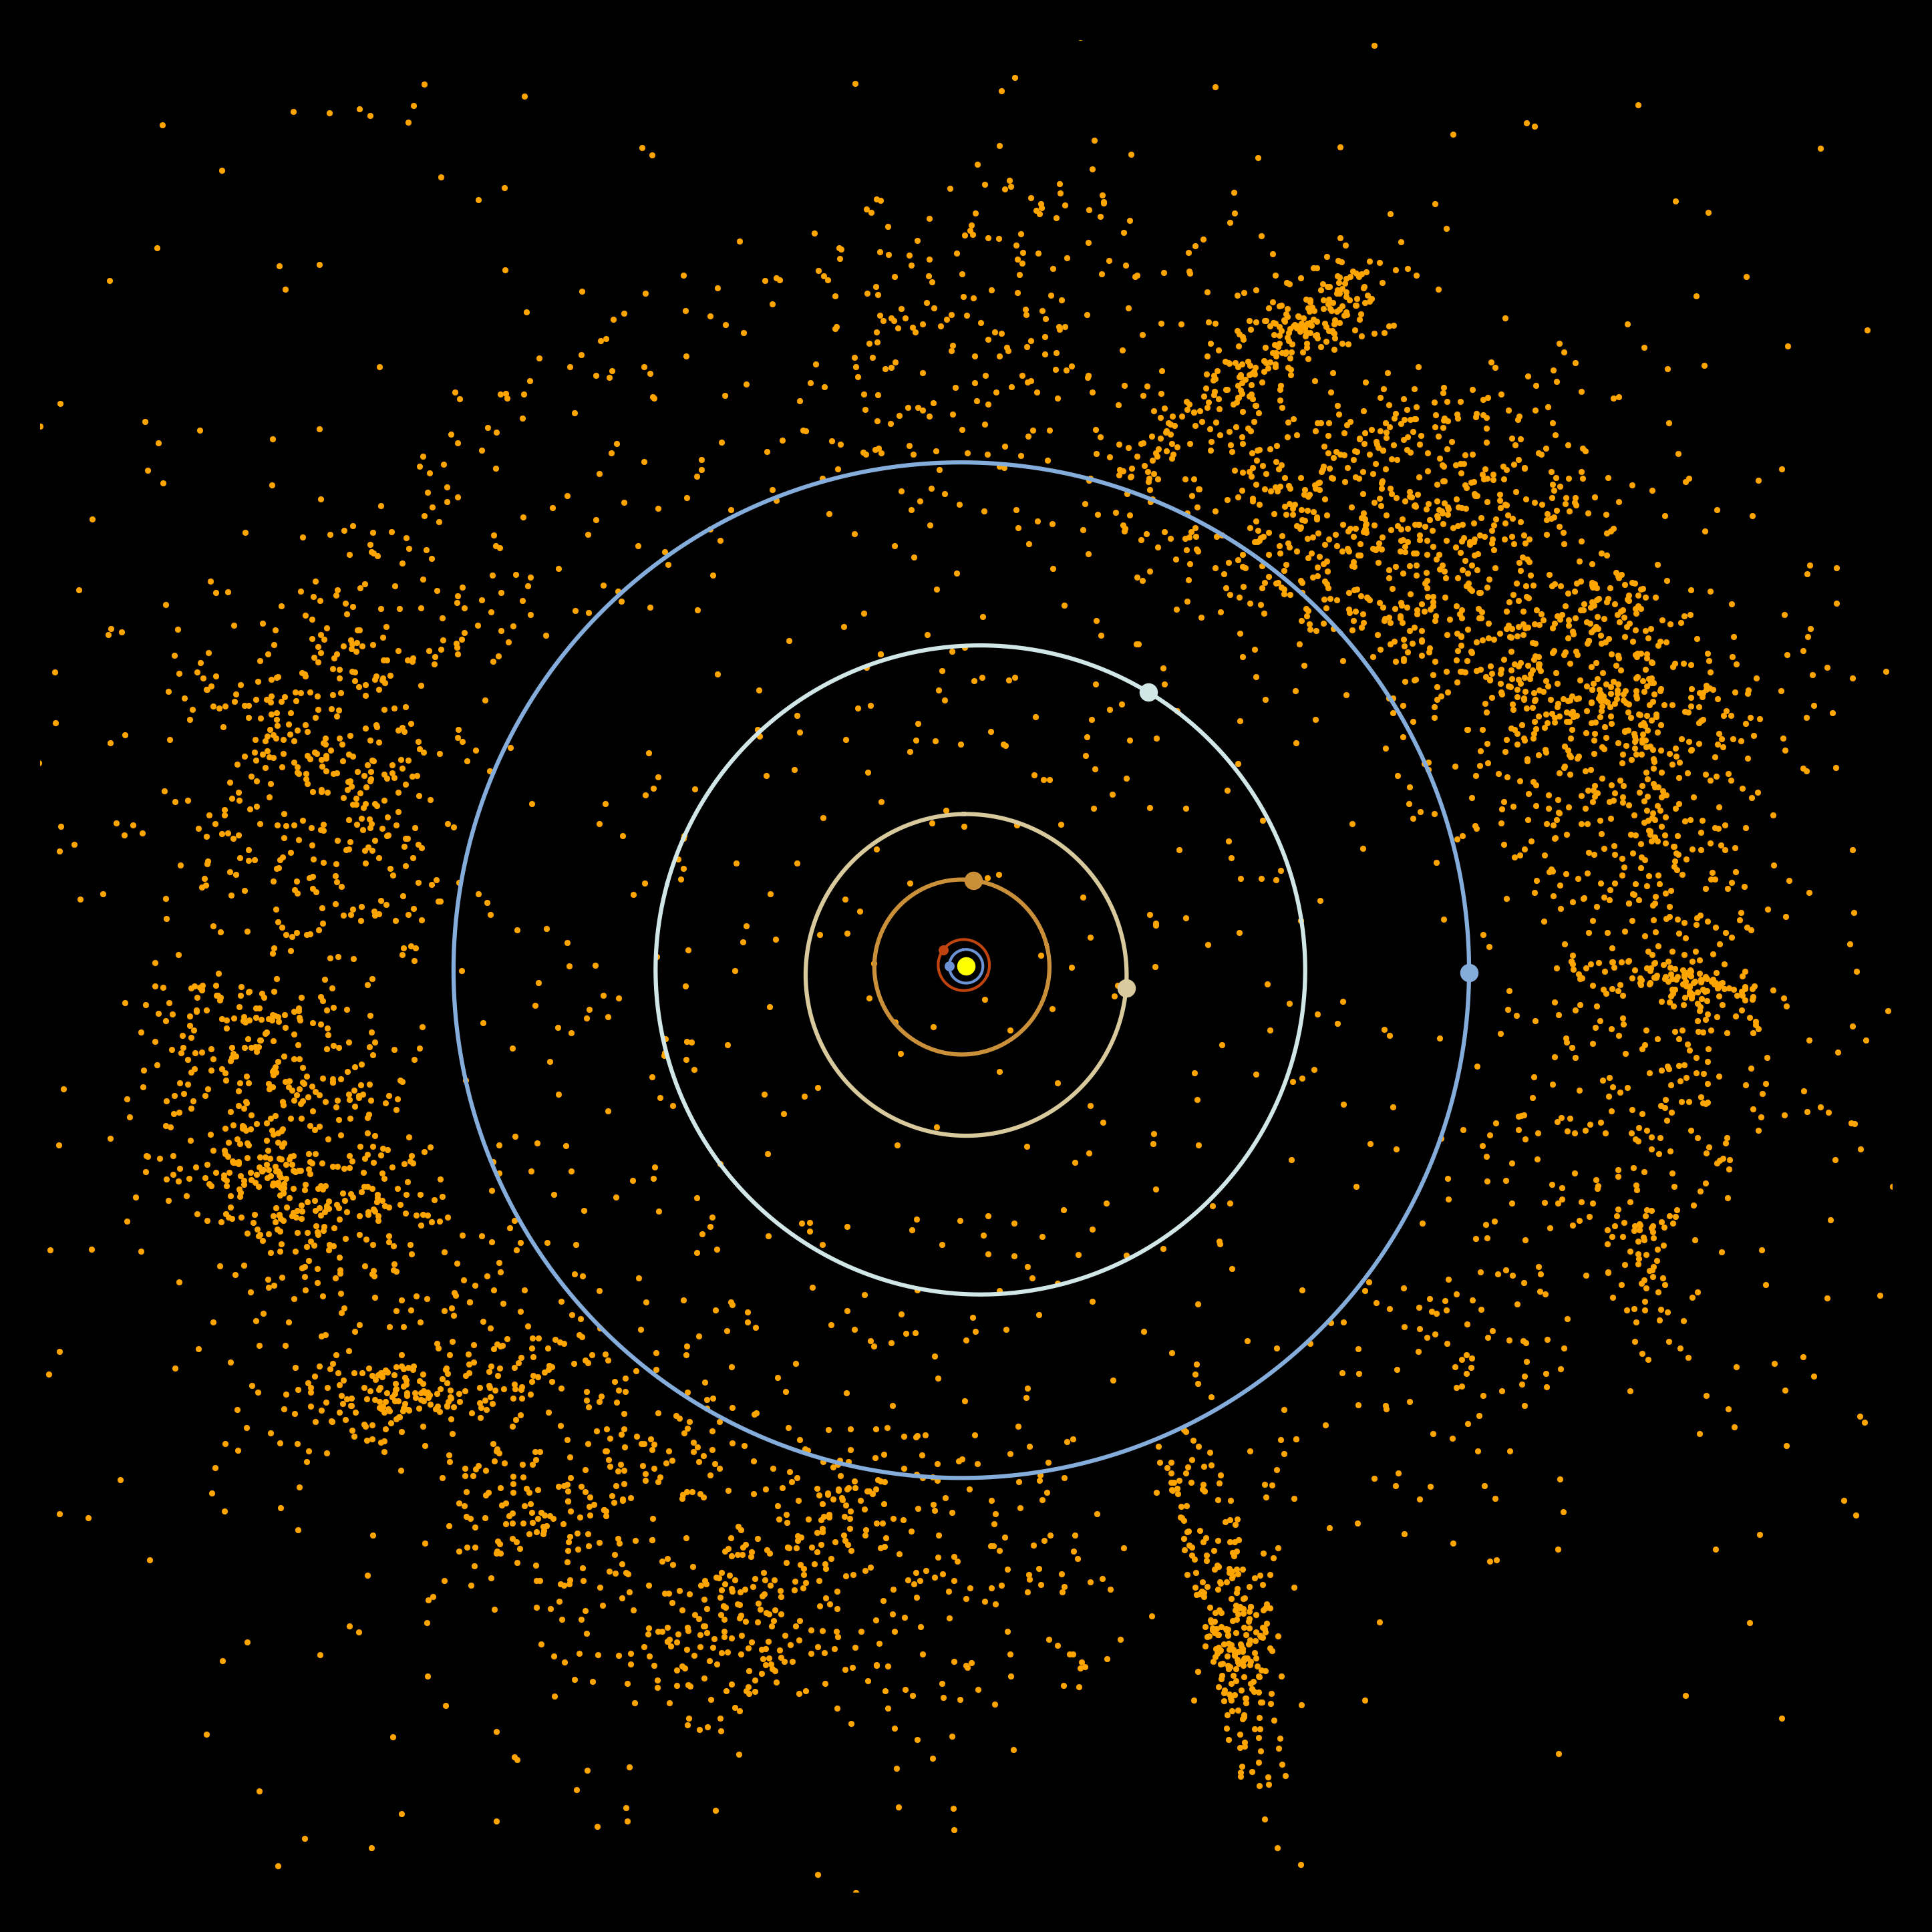

In [33]:
plotFile = f"TNOs_XY_{dateTag}.png"
aMax = 55.0
showDwarfs = False

plt.style.use('dark_background')

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(-aMax,aMax)
ax.set_xticks([])
ax.set_ylim(-aMax,aMax)
ax.set_yticks([])
ax.set_axis_off()

ax.set_aspect(True)

# plot the TNOs and Centaurs

ax.plot(xTNO,yTNO,'o',ms=1,mfc='orange',mec='orange',mew=0.1,alpha=1,zorder=7)

# Planet orbits

for planet in planets:
    if planet in outer:
        pms = 3
        olw = 0.75
    else:
        pms = 1.5
        olw = 0.5
        
    ax.plot(xOrb[planet],yOrb[planet],'-',lw=olw,color=colors[planet],zorder=9)
    ax.plot(xP[planet],yP[planet],'o',ms=pms,mfc=colors[planet],mec=colors[planet],mew=0.3,alpha=1,zorder=10)
        
# and the sun

ax.plot(0,0,'o',ms=3,mfc='yellow',mec='yellow',mew=0.3,alpha=1,zorder=10)

# highlight the trans-neptunian dwarf planets

if showDwarfs:
    for body in dwarfs:
        ax.plot(xP[body],yP[body],'o',ms=3,mfc=colors[body],mec=colors[body],mew=0.3,alpha=0.75,zorder=10)

    for body in ['Pluto','Arrokoth']:
        ax.plot(xOrb[body],yOrb[body],'-',lw=0.5,color=colors[body],zorder=9)
        ax.plot(xP[body],yP[body],'o',ms=2,mfc=colors[body],mec="white",mew=0.3,alpha=1,zorder=10)
    
# save hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='black')

plt.show()

### YZ ecliptic plane projection

For this projection we don't plot the planets to keep it uncluttered.  You can try it by setting
`showPlanets=True` in the cell.

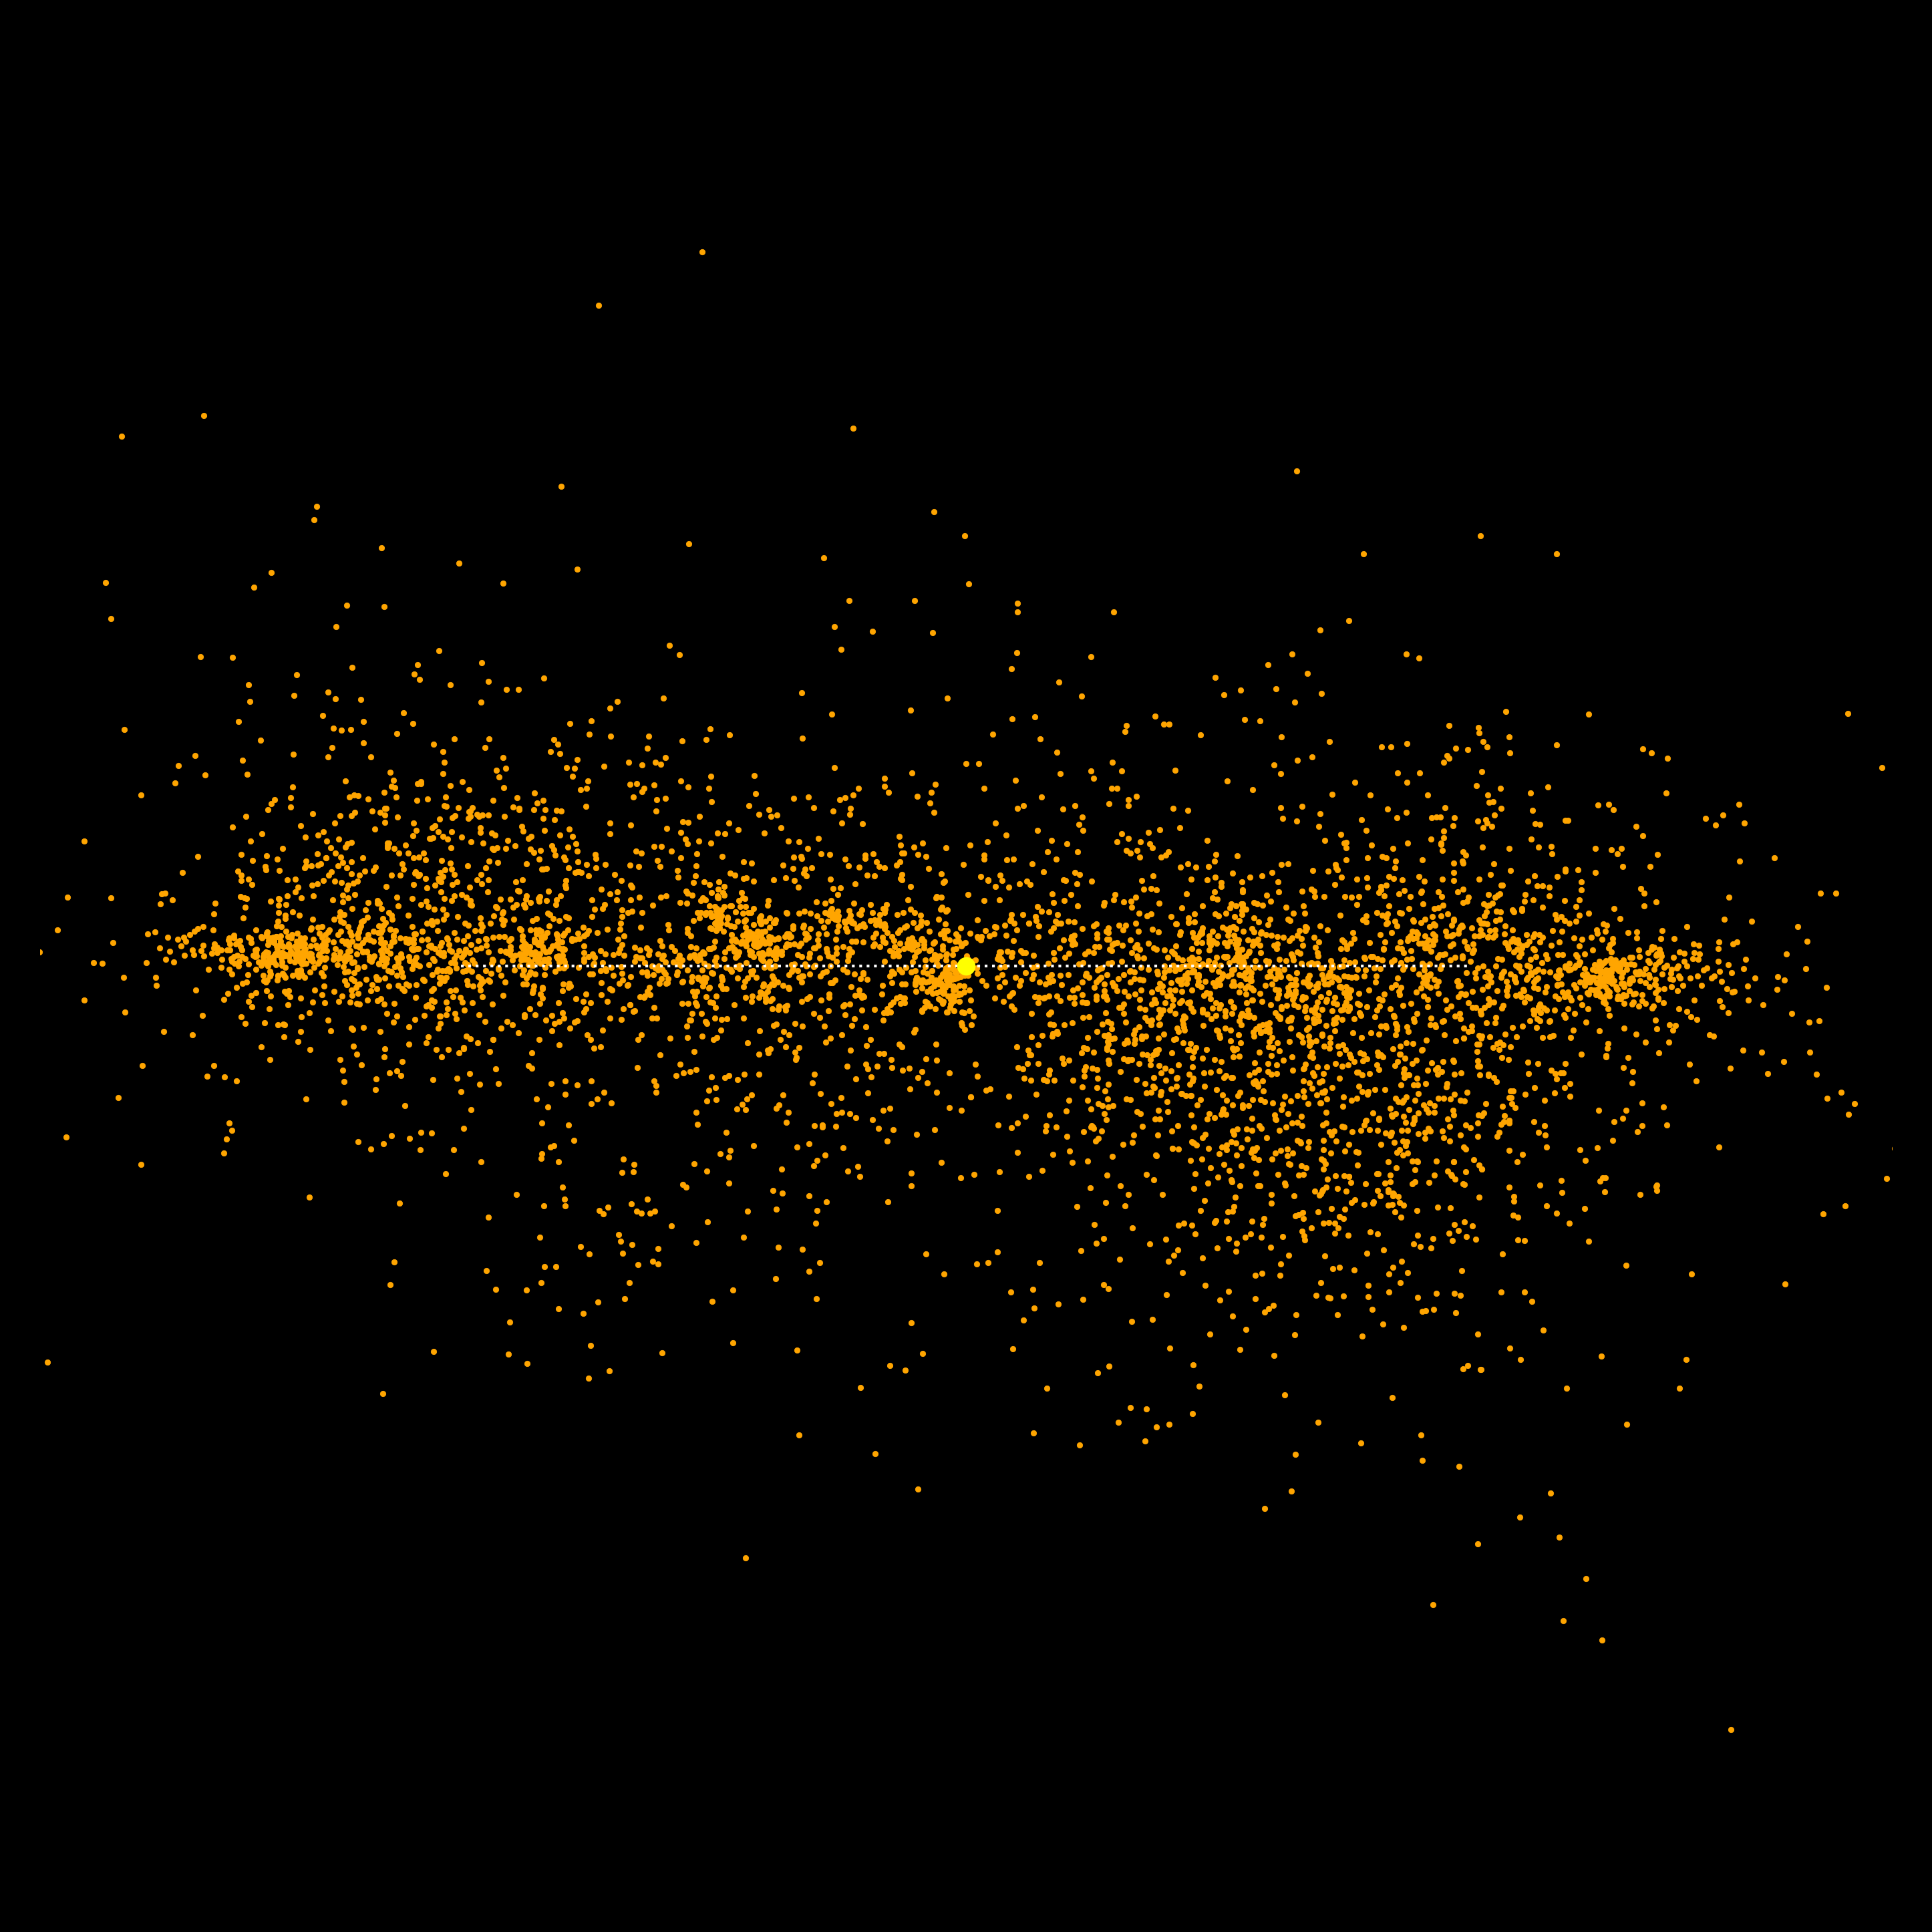

In [34]:
plotFile = f"TNOs_YZ_{dateTag}.png"
axMax = 55.0
ayMax = 55.0

showPlanets = False
showDwarfs = False

plt.style.use('dark_background')

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

aMax = 55.0

ax.set_xlim(-axMax,axMax)
ax.set_xticks([])
ax.set_ylim(-ayMax,ayMax)
ax.set_yticks([])
ax.set_axis_off()

ax.set_aspect(True)

# plot the TNOs and Centaurs

ax.plot(yTNO,zTNO,'o',ms=1,mfc='orange',mec='orange',mew=0.1,alpha=1,zorder=7)

# and the sun

ax.plot(0,0,'o',ms=3,mfc='yellow',mec='yellow',mew=0.3,alpha=1,zorder=10)

# outer planet orbits or just the ecliptic

if showPlanets:
    for planet in outer:
        ax.plot(yOrb[planet],zOrb[planet],'-',lw=0.75,color=colors[planet],zorder=6)
        ax.plot(yP[planet],zP[planet],'o',ms=3,mfc=colors[planet],mec=colors[planet],mew=0.3,alpha=1,zorder=7)
else:
    # ecliptic +/-30au (Neptune)

    ax.hlines([0],-30,30,colors=["white"],ls=[":"],lw=0.5,zorder=9)        

# highlight the trans-neptunian dwarf planets

if showDwarfs:
    for body in dwarfs:
        ax.plot(yP[body],zP[body],'o',ms=3,mfc=colors[body],mec=colors[body],mew=0.3,alpha=0.75,zorder=10)
        
# save hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='black')

plt.show()